In [1]:
# %% Cell 1: Enhanced Imports and Configuration
"""
Machine Learning Optimization for SRK/T Formula in FacoDMEK Eyes
Required packages: pip install pandas numpy matplotlib seaborn scikit-learn scipy openpyxl scikit-optimize
"""

# Standard library imports
import json
import warnings
from datetime import datetime
from pathlib import Path

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, 
    GridSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.base import clone

# Optimization
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy import stats

# Bayesian optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    SKOPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not installed. Install with: pip install scikit-optimize")
    SKOPT_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Global configuration
class Config:
    RANDOM_SEED = 42  # Change for different results
    TEST_SIZE = 0.30  # 30% test set
    CV_FOLDS = 3      # Cross-validation folds
    N_BOOTSTRAP = 1000  # Bootstrap iterations
    
    # File paths
    DATA_FILE = 'FacoDMEK.xlsx'
    OUTPUT_DIR = Path('output')
    
    # Plotting
    FIGURE_DPI = 100
    FIGURE_SIZE = (10, 6)

# Set random seeds
np.random.seed(Config.RANDOM_SEED)

# Create output directory
Config.OUTPUT_DIR.mkdir(exist_ok=True)

print("Enhanced ML Pipeline for FacoDMEK IOL Calculations")
print("=" * 60)
print(f"Random Seed: {Config.RANDOM_SEED}")
print(f"Test Set Size: {Config.TEST_SIZE * 100:.0f}%")
print(f"Cross-validation Folds: {Config.CV_FOLDS}")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("=" * 60)

Enhanced ML Pipeline for FacoDMEK IOL Calculations
Random Seed: 42
Test Set Size: 30%
Cross-validation Folds: 3
Output Directory: output


In [2]:
# %% Cell 2: Data Loading and Advanced Feature Engineering
"""Load data and create clinically meaningful features"""

class DataProcessor:
    """Handle data loading and feature engineering"""
    
    @staticmethod
    def load_data(filepath):
        """Load and validate data"""
        try:
            df = pd.read_excel(filepath, sheet_name='Cleaned Data')
            print(f"✓ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
            return df
        except Exception as e:
            raise ValueError(f"Error loading data: {e}")
    
    @staticmethod
    def create_features(df):
        """Create derived features based on clinical knowledge"""
        df = df.copy()
        
        # Basic derived features
        df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2
        df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
        df['K_Cylinder'] = np.abs(df['K_Astigmatism_Kerato'])
        
        # Ratios and relationships
        df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
        df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']
        
        # Advanced features
        df['K_Spherical_Equivalent'] = df['K_avg_Kerato'] + 0.5 * df['K_Cylinder']
        
        # Categorize axial length
        df['AL_Category'] = pd.cut(
            df['Bio-AL'], 
            bins=[0, 22, 24.5, 26, 100], 
            labels=['short', 'normal', 'long', 'very_long']
        )
        
        # Additional clinical features if available
        if 'Bio-ACD' in df.columns and 'Bio-LT' in df.columns:
            df['Anterior_Segment_Depth'] = df['Bio-ACD'] + 0.5 * df['Bio-LT']
            if 'Bio-AL' in df.columns:
                df['LP_Factor'] = df['Bio-ACD'] / (df['Bio-AL'] - df['Bio-LT'])
        
        # CCT categories if available
        if 'CCT' in df.columns:
            df['CCT_Category'] = pd.cut(
                df['CCT'],
                bins=[0, 500, 550, 600, 1000],
                labels=['thin', 'normal', 'thick', 'very_thick']
            )
            df['CCT_K_Interaction'] = df['CCT'] * df['K_avg_Kerato'] / 1000
        
        return df
    
    @staticmethod
    def get_feature_summary(df):
        """Print feature summary statistics"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print("\nFeature Summary:")
        print("-" * 60)
        for col in ['Bio-AL', 'K_avg_Kerato', 'CCT', 'IOL Power']:
            if col in df.columns:
                print(f"{col:20s}: μ={df[col].mean():.2f}, σ={df[col].std():.2f}, "
                      f"range=[{df[col].min():.1f}, {df[col].max():.1f}]")

# Load and process data
processor = DataProcessor()
df = processor.load_data(Config.DATA_FILE)
df = processor.create_features(df)
processor.get_feature_summary(df)

print(f"\n✓ Feature engineering completed: {len(df.columns)} total features")

✓ Data loaded successfully: 97 rows, 29 columns

Feature Summary:
------------------------------------------------------------
Bio-AL              : μ=23.83, σ=1.38, range=[21.2, 28.2]
K_avg_Kerato        : μ=43.60, σ=1.88, range=[39.0, 47.3]
CCT                 : μ=620.57, σ=79.40, range=[448.0, 880.0]
IOL Power           : μ=21.46, σ=4.12, range=[11.0, 30.0]

✓ Feature engineering completed: 40 total features


In [3]:
# %% Cell 3: Advanced Train/Test Split with Validation
"""Create train/test split with proper stratification and validation"""

class DataSplitter:
    """Handle data splitting with validation"""
    
    def __init__(self, test_size=0.3, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.required_cols = [
            'Bio-AL', 'K_avg_Kerato', 'IOL Power', 
            'PostOP Spherical Equivalent', 'A-Constant'
        ]
    
    def split_data(self, df):
        """Create train/test split with stratification"""
        # Filter complete cases
        df_complete = df[df[self.required_cols].notna().all(axis=1)].copy()
        
        print(f"Complete cases: {len(df_complete)} / {len(df)} ({len(df_complete)/len(df)*100:.1f}%)")
        
        # Stratified split by AL category
        df_train, df_test = train_test_split(
            df_complete,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=df_complete['AL_Category']
        )
        
        return df_train, df_test
    
    def validate_split(self, df_train, df_test):
        """Validate the data split"""
        print("\nData Split Validation:")
        print("-" * 40)
        print(f"Training set: {len(df_train)} eyes ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)")
        print(f"Test set: {len(df_test)} eyes ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)")
        
        # Check distributions
        print("\nAL Distribution:")
        for name, data in [("Train", df_train), ("Test", df_test)]:
            dist = data['AL_Category'].value_counts(normalize=True).sort_index()
            print(f"{name}: " + " | ".join([f"{cat}: {pct*100:.1f}%" for cat, pct in dist.items()]))
        
        # Statistical tests for distribution similarity
        for col in ['Bio-AL', 'K_avg_Kerato']:
            stat, pval = stats.ks_2samp(df_train[col], df_test[col])
            print(f"\nKS test for {col}: p={pval:.3f} {'✓' if pval > 0.05 else '✗'}")

# Split data
splitter = DataSplitter(test_size=Config.TEST_SIZE, random_state=Config.RANDOM_SEED)
df_train_val, df_test = splitter.split_data(df)
splitter.validate_split(df_train_val, df_test)

Complete cases: 97 / 97 (100.0%)

Data Split Validation:
----------------------------------------
Training set: 67 eyes (69.1%)
Test set: 30 eyes (30.9%)

AL Distribution:
Train: short: 7.5% | normal: 65.7% | long: 17.9% | very_long: 9.0%
Test: short: 6.7% | normal: 63.3% | long: 20.0% | very_long: 10.0%

KS test for Bio-AL: p=0.842 ✓

KS test for K_avg_Kerato: p=0.531 ✓


In [4]:
# %% Cell 4: Optimized SRK/T Formula Implementation
"""Enhanced SRK/T formula with safety checks and validation"""

class SRKTCalculator:
    """SRK/T IOL power calculation with enhancements"""
    
    # Standard constants
    NA = 1.336  # Aqueous/vitreous refractive index
    VERTEX = 12.0  # Vertex distance in mm
    
    @staticmethod
    def calculate(AL, K, A_const, nc=1.333):
        """
        Calculate IOL power using SRK/T formula
        
        Parameters:
        -----------
        AL : float - Axial length (mm)
        K : float - Average keratometry (D)
        A_const : float - A-constant
        nc : float - Corneal refractive index (default: 1.333)
        
        Returns:
        --------
        float - IOL power for emmetropia (D)
        """
        # Input validation
        if any(pd.isna([AL, K, A_const])) or K <= 0 or AL <= 0:
            return np.nan
        
        # Bounds checking
        if not (15 < AL < 35) or not (35 < K < 55):
            return np.nan
        
        try:
            # Corneal radius
            r = 337.5 / K
            
            # Axial length correction
            if AL > 24.2:
                LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
            else:
                LCOR = AL
            
            # Corneal width
            Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
            
            # Safety check for corneal height calculation
            discriminant = r**2 - (Cw**2 / 4)
            if discriminant < 0:
                return np.nan
            
            # Corneal height
            H = r - np.sqrt(discriminant)
            
            # ACD estimation
            ACDconst = 0.62467 * A_const - 68.747
            offset = ACDconst - 3.336
            ACDest = H + offset
            
            # Retinal thickness
            RETHICK = 0.65696 - 0.02029 * AL
            LOPT = AL + RETHICK
            
            # IOL power calculation
            ncm1 = nc - 1
            numerator = 1000 * SRKTCalculator.NA * (SRKTCalculator.NA * r - ncm1 * LOPT)
            denominator = (LOPT - ACDest) * (SRKTCalculator.NA * r - ncm1 * ACDest)
            
            if denominator == 0:
                return np.nan
                
            IOL = numerator / denominator
            
            # Sanity check on IOL power
            if not (-10 < IOL < 40):
                return np.nan
                
            return IOL
            
        except Exception:
            return np.nan
    
    @staticmethod
    def calculate_error(row, nc=1.333):
        """Calculate prediction error for a single case"""
        iol_pred = SRKTCalculator.calculate(
            row['Bio-AL'], 
            row['K_avg_Kerato'], 
            row['A-Constant'], 
            nc
        )
        
        if pd.isna(iol_pred):
            return np.nan
        
        expected_se = -(row['IOL Power'] - iol_pred)
        error = row['PostOP Spherical Equivalent'] - expected_se
        
        return error

# Calculate baseline performance
print("\nCalculating baseline SRK/T performance...")
df_train_val['SRKT_Baseline'] = df_train_val.apply(
    lambda row: SRKTCalculator.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
    axis=1
)

df_train_val['SRKT_Error'] = df_train_val.apply(
    lambda row: SRKTCalculator.calculate_error(row),
    axis=1
)

# Performance metrics
valid_errors = df_train_val['SRKT_Error'].dropna()
baseline_mae = valid_errors.abs().mean()
baseline_std = valid_errors.abs().std()

print(f"\nBaseline Performance:")
print(f"  MAE: {baseline_mae:.3f} D")
print(f"  SD:  {baseline_std:.3f} D")
print(f"  n:   {len(valid_errors)} eyes")
print(f"\nTarget: Beat {baseline_mae - 0.05:.3f} D for clinical significance")


Calculating baseline SRK/T performance...

Baseline Performance:
  MAE: 1.637 D
  SD:  1.861 D
  n:   67 eyes

Target: Beat 1.587 D for clinical significance


Testing 41 nc values from 1.33 to 1.338
  Progress: 10/41
  Progress: 20/41
  Progress: 30/41
  Progress: 40/41

✓ Optimization Complete!
  Optimal nc: 1.33000
  CV MAE: 1.413 D


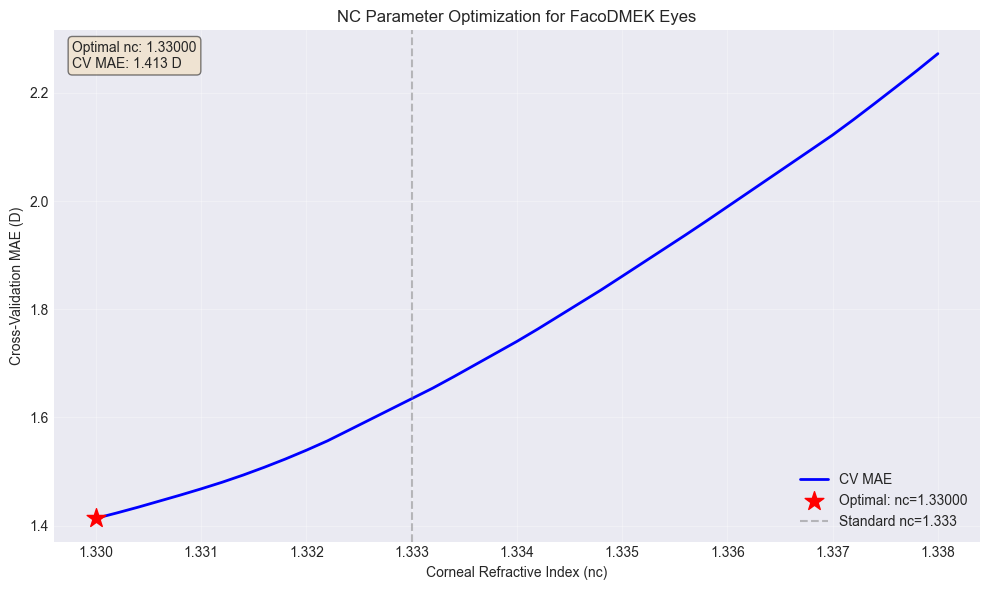


Training Set Performance:
  Baseline MAE: 1.637 D
  Optimized MAE: 1.420 D
  Improvement: 13.3%


In [5]:
# %% Cell 5: Optimized NC Parameter Search
"""Grid search optimization for corneal refractive index"""

class NCOptimizer:
    """Optimize corneal refractive index using cross-validation"""
    
    def __init__(self, nc_range=(1.330, 1.338), n_points=41):
        self.nc_range = nc_range
        self.nc_values = np.linspace(nc_range[0], nc_range[1], n_points)
        self.results = None
        
    def objective_function(self, nc, df, cv_folds=3, random_state=42):
        """Calculate CV score for given nc value"""
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        fold_scores = []
        
        for train_idx, val_idx in kf.split(df):
            val_data = df.iloc[val_idx]
            
            # Calculate errors for validation fold
            errors = val_data.apply(
                lambda row: SRKTCalculator.calculate_error(row, nc=nc),
                axis=1
            ).dropna()
            
            if len(errors) > 0:
                fold_scores.append(errors.abs().mean())
        
        return np.mean(fold_scores) if fold_scores else np.inf
    
    def optimize(self, df_train):
        """Find optimal nc value"""
        print(f"Testing {len(self.nc_values)} nc values from {self.nc_range[0]} to {self.nc_range[1]}")
        
        # Filter training data
        df_opt = df_train[df_train['SRKT_Error'].notna()].copy()
        
        # Calculate scores
        scores = []
        for i, nc in enumerate(self.nc_values):
            score = self.objective_function(nc, df_opt, cv_folds=Config.CV_FOLDS, 
                                          random_state=Config.RANDOM_SEED)
            scores.append(score)
            
            if (i + 1) % 10 == 0:
                print(f"  Progress: {i+1}/{len(self.nc_values)}")
        
        # Find optimal value
        scores = np.array(scores)
        best_idx = np.argmin(scores)
        self.optimal_nc = self.nc_values[best_idx]
        self.optimal_score = scores[best_idx]
        self.results = pd.DataFrame({'nc': self.nc_values, 'cv_mae': scores})
        
        return self.optimal_nc, self.optimal_score
    
    def plot_results(self, save_path=None):
        """Visualize optimization results"""
        if self.results is None:
            return
        
        plt.figure(figsize=Config.FIGURE_SIZE)
        
        # Main plot
        plt.plot(self.results['nc'], self.results['cv_mae'], 'b-', linewidth=2, label='CV MAE')
        plt.scatter(self.optimal_nc, self.optimal_score, s=200, c='red', 
                   marker='*', zorder=5, label=f'Optimal: nc={self.optimal_nc:.5f}')
        
        # Reference line
        plt.axvline(x=1.333, color='gray', linestyle='--', alpha=0.5, label='Standard nc=1.333')
        
        # Formatting
        plt.xlabel('Corneal Refractive Index (nc)')
        plt.ylabel('Cross-Validation MAE (D)')
        plt.title('NC Parameter Optimization for FacoDMEK Eyes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add text box with results
        textstr = f'Optimal nc: {self.optimal_nc:.5f}\nCV MAE: {self.optimal_score:.3f} D'
        plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()

# Optimize nc
optimizer = NCOptimizer(nc_range=(1.330, 1.338), n_points=41)
df_opt_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

optimal_nc, optimal_score = optimizer.optimize(df_opt_train)

print(f"\n✓ Optimization Complete!")
print(f"  Optimal nc: {optimal_nc:.5f}")
print(f"  CV MAE: {optimal_score:.3f} D")

# Visualize
optimizer.plot_results(save_path=Config.OUTPUT_DIR / 'nc_optimization.png')

# Apply optimal nc
df_opt_train['Error_ML_nc'] = df_opt_train.apply(
    lambda row: SRKTCalculator.calculate_error(row, nc=optimal_nc),
    axis=1
)

ml_nc_mae = df_opt_train['Error_ML_nc'].abs().mean()
improvement = (baseline_mae - ml_nc_mae) / baseline_mae * 100

print(f"\nTraining Set Performance:")
print(f"  Baseline MAE: {baseline_mae:.3f} D")
print(f"  Optimized MAE: {ml_nc_mae:.3f} D")
print(f"  Improvement: {improvement:.1f}%")

In [6]:
# %% Cell 6: Advanced Ensemble with Bayesian Optimization
"""Build optimized ensemble model for residual error correction"""

class EnsembleBuilder:
    """Build and optimize ensemble model"""
    
    def __init__(self, feature_cols=None, use_bayesian=True):
        self.feature_cols = feature_cols or [
            'Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder',
            'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT'
        ]
        self.use_bayesian = use_bayesian and SKOPT_AVAILABLE
        self.models = {}
        self.ensemble = None
        self.imputer = KNNImputer(n_neighbors=5)
        
    def add_optional_features(self, df):
        """Add optional features if available"""
        optional_features = [
            'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT',
            'Anterior_Segment_Depth', 'LP_Factor', 'CCT_K_Interaction'
        ]
        
        for feat in optional_features:
            if feat in df.columns and feat not in self.feature_cols:
                self.feature_cols.append(feat)
        
        return self.feature_cols
    
    def prepare_features(self, df, fit_imputer=True):
        """Prepare features with imputation"""
        X = df[self.feature_cols].copy()
        
        if fit_imputer:
            X_imputed = self.imputer.fit_transform(X)
        else:
            X_imputed = self.imputer.transform(X)
        
        return pd.DataFrame(X_imputed, columns=self.feature_cols, index=X.index)
    
    def create_base_models(self):
        """Create base model pipelines"""
        models = {
            'ridge': Pipeline([
                ('scaler', RobustScaler()),
                ('model', Ridge())
            ]),
            'huber': Pipeline([
                ('scaler', RobustScaler()),
                ('model', HuberRegressor())
            ]),
            'rf': Pipeline([
                ('scaler', RobustScaler()),
                ('model', RandomForestRegressor(random_state=Config.RANDOM_SEED))
            ]),
            'elastic': Pipeline([
                ('scaler', StandardScaler()),
                ('model', ElasticNet(random_state=Config.RANDOM_SEED))
            ])
        }
        
        return models
    
    def get_search_spaces(self):
        """Define hyperparameter search spaces"""
        return {
            'ridge': {
                'model__alpha': Real(0.1, 100.0, prior='log-uniform')
            },
            'huber': {
                'model__epsilon': Real(1.0, 2.0),
                'model__alpha': Real(0.001, 0.1, prior='log-uniform')
            },
            'rf': {
                'model__n_estimators': Integer(10, 50),
                'model__max_depth': Integer(2, 5),
                'model__min_samples_split': Integer(10, 30),
                'model__min_samples_leaf': Integer(5, 20)
            },
            'elastic': {
                'model__alpha': Real(0.01, 1.0, prior='log-uniform'),
                'model__l1_ratio': Real(0.1, 0.9)
            }
        }
    
    def optimize_models(self, X_train, y_train):
        """Optimize individual models"""
        base_models = self.create_base_models()
        
        if self.use_bayesian:
            print("Using Bayesian optimization for hyperparameter tuning...")
            search_spaces = self.get_search_spaces()
            
            for name, model in base_models.items():
                print(f"\nOptimizing {name}...")
                
                optimizer = BayesSearchCV(
                    model,
                    search_spaces[name],
                    n_iter=20 if name != 'rf' else 30,
                    cv=Config.CV_FOLDS,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    random_state=Config.RANDOM_SEED
                )
                
                optimizer.fit(X_train, y_train)
                self.models[name] = optimizer.best_estimator_
                
                print(f"  Best params: {optimizer.best_params_}")
                print(f"  Best CV MAE: {-optimizer.best_score_:.3f}")
        else:
            print("Using default hyperparameters...")
            # Use reasonable defaults
            defaults = {
                'ridge': {'model__alpha': 10.0},
                'huber': {'model__epsilon': 1.5, 'model__alpha': 0.01},
                'rf': {'model__n_estimators': 20, 'model__max_depth': 3},
                'elastic': {'model__alpha': 0.1, 'model__l1_ratio': 0.5}
            }
            
            for name, model in base_models.items():
                model.set_params(**defaults[name])
                model.fit(X_train, y_train)
                self.models[name] = model
                
                # Calculate CV score
                cv_scores = cross_val_score(
                    model, X_train, y_train,
                    cv=Config.CV_FOLDS,
                    scoring='neg_mean_absolute_error'
                )
                print(f"{name}: CV MAE = {-cv_scores.mean():.3f}")
    
    def create_ensemble(self, X_train, y_train):
        """Create and train ensemble"""
        # Optimize individual models
        self.optimize_models(X_train, y_train)
        
        # Create voting ensemble
        self.ensemble = VotingRegressor([
            (name, model) for name, model in self.models.items()
        ])
        
        # Train ensemble
        self.ensemble.fit(X_train, y_train)
        
        # Evaluate ensemble
        cv_scores = cross_val_score(
            self.ensemble, X_train, y_train,
            cv=Config.CV_FOLDS,
            scoring='neg_mean_absolute_error'
        )
        
        print(f"\nEnsemble CV MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        
        return self.ensemble
    
    def optimize_dampening(self, X_train, y_train, df_train, nc_predictions):
        """Find optimal dampening factor"""
        dampening_range = np.arange(0.3, 0.8, 0.1)
        best_dampening = 0.5
        best_mae = float('inf')
        
        print("\nOptimizing dampening factor...")
        
        # Get ensemble predictions
        ensemble_corrections = self.ensemble.predict(X_train)
        
        for damp in dampening_range:
            # Apply dampened corrections
            final_predictions = nc_predictions + damp * ensemble_corrections
            
            # Calculate error
            expected_se = -(df_train['IOL Power'] - final_predictions)
            errors = df_train['PostOP Spherical Equivalent'] - expected_se
            mae = errors.abs().mean()
            
            print(f"  Dampening {damp:.1f}: MAE = {mae:.3f}")
            
            if mae < best_mae:
                best_mae = mae
                best_dampening = damp
        
        return best_dampening, ensemble_corrections

# Build ensemble
print("\nBuilding ML Ensemble...")
print("=" * 60)

builder = EnsembleBuilder()
builder.add_optional_features(df_opt_train)

print(f"Using {len(builder.feature_cols)} features:")
for i, feat in enumerate(builder.feature_cols, 1):
    print(f"  {i:2d}. {feat}")

# Prepare data
X_train = builder.prepare_features(df_opt_train, fit_imputer=True)
y_residuals = df_opt_train['Error_ML_nc']

# Build ensemble
ensemble = builder.create_ensemble(X_train, y_residuals)

# Optimize dampening
nc_predictions = df_opt_train.apply(
    lambda row: SRKTCalculator.calculate(
        row['Bio-AL'], row['K_avg_Kerato'], 
        row['A-Constant'], nc=optimal_nc
    ),
    axis=1
)

best_dampening, ensemble_corrections = builder.optimize_dampening(
    X_train, y_residuals, df_opt_train, nc_predictions
)

print(f"\n✓ Best dampening factor: {best_dampening:.1f}")

# Apply final corrections
df_opt_train['SRKT_Final'] = nc_predictions + best_dampening * ensemble_corrections
df_opt_train['Error_Final'] = df_opt_train.apply(
    lambda row: row['PostOP Spherical Equivalent'] - (-(row['IOL Power'] - row['SRKT_Final'])),
    axis=1
)

# Final performance
final_mae = df_opt_train['Error_Final'].abs().mean()
total_improvement = (baseline_mae - final_mae) / baseline_mae * 100

print(f"\nFinal Training Performance:")
print(f"  MAE: {final_mae:.3f} D")
print(f"  Total improvement: {total_improvement:.1f}%")

# Save model info
model_info = {
    'optimal_nc': optimal_nc,
    'ensemble': ensemble,
    'builder': builder,
    'dampening_factor': best_dampening,
    'random_seed': Config.RANDOM_SEED,
    'feature_cols': builder.feature_cols,
    'imputer': builder.imputer
}


Building ML Ensemble...
Using 14 features:
   1. Bio-AL
   2. K_avg_Kerato
   3. A-Constant
   4. K_Cylinder
   5. Post_Ant_Ratio
   6. AL_K_Ratio
   7. CCT
   8. Posterior Km
   9. Anterior Km
  10. Bio-ACD
  11. Bio-LT
  12. Anterior_Segment_Depth
  13. LP_Factor
  14. CCT_K_Interaction
Using Bayesian optimization for hyperparameter tuning...

Optimizing ridge...
  Best params: OrderedDict({'model__alpha': 100.0})
  Best CV MAE: 1.468

Optimizing huber...
  Best params: OrderedDict({'model__alpha': 0.1, 'model__epsilon': 1.0})
  Best CV MAE: 1.592

Optimizing rf...
  Best params: OrderedDict({'model__max_depth': 5, 'model__min_samples_leaf': 20, 'model__min_samples_split': 10, 'model__n_estimators': 10})
  Best CV MAE: 1.392

Optimizing elastic...
  Best params: OrderedDict({'model__alpha': 1.0, 'model__l1_ratio': 0.9})
  Best CV MAE: 1.404

Ensemble CV MAE: 1.443 (±0.152)

Optimizing dampening factor...
  Dampening 0.3: MAE = 1.358
  Dampening 0.4: MAE = 1.339
  Dampening 0.5: MAE 


Evaluating models on test set...
1. Baseline SRK/T (nc=1.333)...
2. ML-Optimized NC...
3. ML + Ensemble...

Test Set Results Summary:
         Method  n   mae  median_ae   std  rmse  within_025  within_050  within_100  max_error
 Baseline SRK/T 30 1.370      1.120 1.163 1.785       3.333        20.0        46.7      5.820
ML-Optimized NC 30 1.016      0.738 1.077 1.467        23.3        43.3        63.3      5.147
  ML + Ensemble 30 1.000      0.611 1.152 1.512        20.0        46.7        70.0      5.508

Statistical Testing:
------------------------------------------------------------

ML-NC vs Baseline:
  Difference: 0.3540 D
  95% CI: [0.2105, 0.4876]
  p-value: 0.0000
  Significant: Yes ✓

ML+Ensemble vs Baseline:
  Difference: 0.3694 D
  95% CI: [0.1388, 0.6111]
  p-value: 0.0020
  Significant: Yes ✓

ML+Ensemble vs ML-NC:
  Difference: 0.0154 D
  95% CI: [-0.1035, 0.1490]
  p-value: 0.8140
  Significant: No ✗

Additional tests (ML+Ensemble vs Baseline):
  Paired t-test p-val

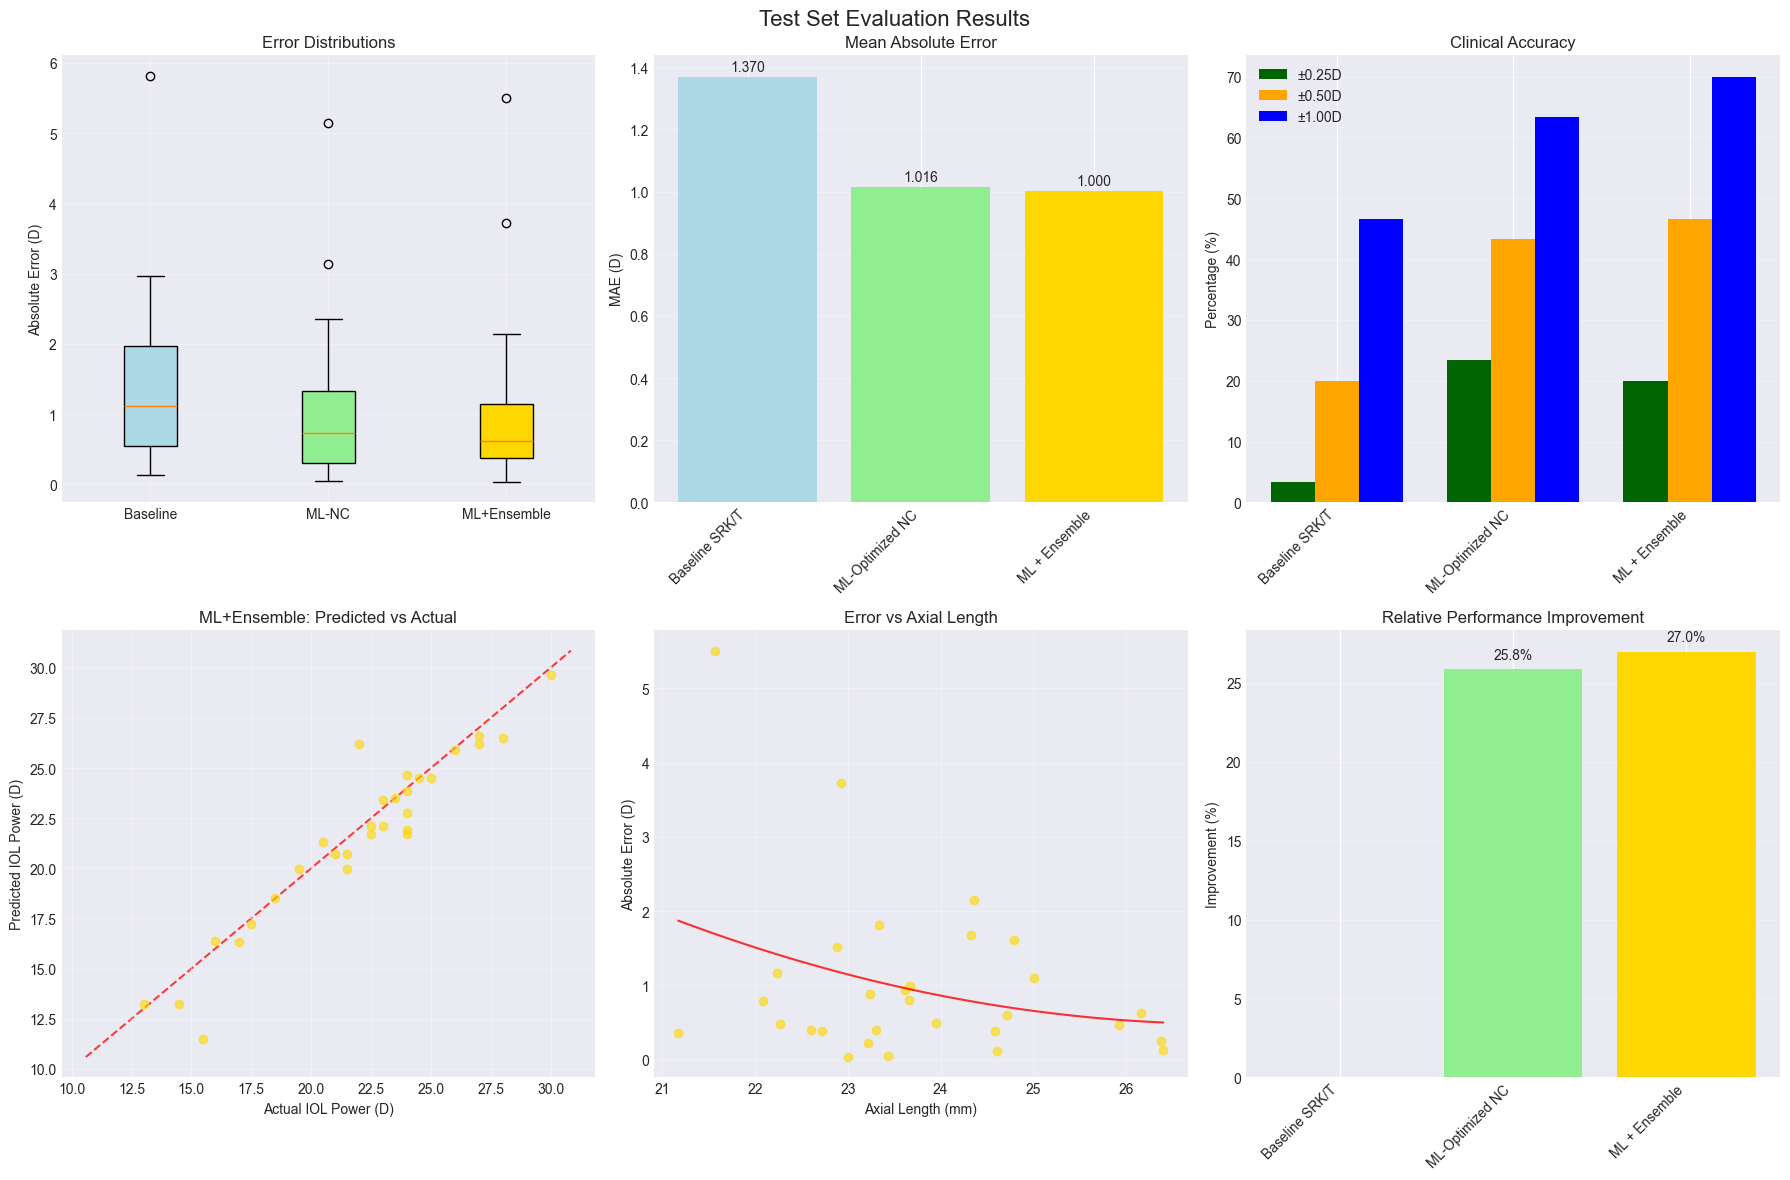


ANALYSIS COMPLETE!
Test set size: 30 eyes
Best method: ML + Ensemble
Best MAE: 1.000 D
Improvement: 27.0%
Random seed: 42


In [7]:
# %% Cell 7: Comprehensive Test Set Evaluation
"""Evaluate all models on held-out test set"""

class ModelEvaluator:
    """Comprehensive model evaluation and comparison"""
    
    def __init__(self, model_info):
        self.model_info = model_info
        self.results = {}
        
    def calculate_clinical_metrics(self, errors):
        """Calculate comprehensive clinical metrics"""
        abs_errors = errors.abs()
        
        return {
            'n': len(errors),
            'mae': abs_errors.mean(),
            'median_ae': abs_errors.median(),
            'std': abs_errors.std(),
            'rmse': np.sqrt((errors ** 2).mean()),
            'max_error': abs_errors.max(),
            'within_025': (abs_errors <= 0.25).mean() * 100,
            'within_050': (abs_errors <= 0.50).mean() * 100,
            'within_100': (abs_errors <= 1.00).mean() * 100,
            'within_200': (abs_errors <= 2.00).mean() * 100
        }
    
    def bootstrap_confidence_interval(self, errors1, errors2, n_bootstrap=1000):
        """Calculate bootstrap confidence intervals for paired differences"""
        np.random.seed(Config.RANDOM_SEED)
        
        # Align indices
        common_idx = errors1.index.intersection(errors2.index)
        e1 = errors1[common_idx].values
        e2 = errors2[common_idx].values
        
        # Observed difference
        observed_diff = np.mean(e1) - np.mean(e2)
        
        # Bootstrap
        bootstrap_diffs = []
        n_samples = len(e1)
        
        for _ in range(n_bootstrap):
            idx = np.random.choice(n_samples, n_samples, replace=True)
            boot_diff = np.mean(e1[idx]) - np.mean(e2[idx])
            bootstrap_diffs.append(boot_diff)
        
        bootstrap_diffs = np.array(bootstrap_diffs)
        
        # Statistics
        ci_lower = np.percentile(bootstrap_diffs, 2.5)
        ci_upper = np.percentile(bootstrap_diffs, 97.5)
        p_value = np.sum(bootstrap_diffs <= 0) / n_bootstrap * 2
        p_value = min(p_value, 1.0)
        
        return {
            'difference': observed_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'p_value': p_value,
            'bootstrap_diffs': bootstrap_diffs
        }
    
    def evaluate_all_models(self, df_test):
        """Evaluate all model variants"""
        print("\nEvaluating models on test set...")
        print("=" * 60)
        
        df_eval = df_test.copy()
        
        # 1. Baseline SRK/T
        print("1. Baseline SRK/T (nc=1.333)...")
        df_eval['Error_Baseline'] = df_eval.apply(
            lambda row: SRKTCalculator.calculate_error(row, nc=1.333),
            axis=1
        )
        
        # 2. Optimized NC
        print("2. ML-Optimized NC...")
        df_eval['Error_ML_nc'] = df_eval.apply(
            lambda row: SRKTCalculator.calculate_error(row, nc=self.model_info['optimal_nc']),
            axis=1
        )
        
        # 3. ML + Ensemble
        print("3. ML + Ensemble...")
        
        # Prepare features
        builder = self.model_info['builder']
        X_test = builder.prepare_features(df_eval, fit_imputer=False)
        
        # Get predictions
        nc_predictions = df_eval.apply(
            lambda row: SRKTCalculator.calculate(
                row['Bio-AL'], row['K_avg_Kerato'], 
                row['A-Constant'], nc=self.model_info['optimal_nc']
            ),
            axis=1
        )
        
        ensemble_corrections = self.model_info['ensemble'].predict(X_test)
        final_predictions = nc_predictions + self.model_info['dampening_factor'] * ensemble_corrections
        
        df_eval['SRKT_Final'] = final_predictions
        df_eval['Error_Final'] = df_eval.apply(
            lambda row: row['PostOP Spherical Equivalent'] - (-(row['IOL Power'] - row['SRKT_Final'])),
            axis=1
        )
        
        # Calculate metrics for each method
        methods = {
            'Baseline SRK/T': df_eval['Error_Baseline'],
            'ML-Optimized NC': df_eval['Error_ML_nc'],
            'ML + Ensemble': df_eval['Error_Final']
        }
        
        results_summary = []
        for method, errors in methods.items():
            metrics = self.calculate_clinical_metrics(errors.dropna())
            metrics['Method'] = method
            results_summary.append(metrics)
            self.results[method] = metrics
        
        # Create results dataframe
        self.results_df = pd.DataFrame(results_summary)
        
        # Reorder columns
        col_order = ['Method', 'n', 'mae', 'median_ae', 'std', 'rmse', 
                     'within_025', 'within_050', 'within_100', 'max_error']
        self.results_df = self.results_df[col_order]
        
        return df_eval, self.results_df
    
    def perform_statistical_tests(self, df_eval):
        """Perform comprehensive statistical testing"""
        print("\nStatistical Testing:")
        print("-" * 60)
        
        baseline_errors = df_eval['Error_Baseline'].abs().dropna()
        ml_nc_errors = df_eval['Error_ML_nc'].abs().dropna()
        final_errors = df_eval['Error_Final'].abs().dropna()
        
        # Bootstrap tests
        tests = [
            ("ML-NC vs Baseline", baseline_errors, ml_nc_errors),
            ("ML+Ensemble vs Baseline", baseline_errors, final_errors),
            ("ML+Ensemble vs ML-NC", ml_nc_errors, final_errors)
        ]
        
        test_results = []
        for name, errors1, errors2 in tests:
            result = self.bootstrap_confidence_interval(errors1, errors2)
            
            print(f"\n{name}:")
            print(f"  Difference: {result['difference']:.4f} D")
            print(f"  95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
            print(f"  p-value: {result['p_value']:.4f}")
            print(f"  Significant: {'Yes ✓' if result['p_value'] < 0.05 else 'No ✗'}")
            
            test_results.append({
                'comparison': name,
                **result
            })
        
        # Additional tests
        from scipy.stats import ttest_rel, wilcoxon
        
        common_idx = baseline_errors.index.intersection(final_errors.index)
        if len(common_idx) > 0:
            # Paired t-test
            t_stat, p_ttest = ttest_rel(
                baseline_errors[common_idx], 
                final_errors[common_idx]
            )
            
            # Wilcoxon signed-rank test
            w_stat, p_wilcoxon = wilcoxon(
                baseline_errors[common_idx], 
                final_errors[common_idx]
            )
            
            print(f"\nAdditional tests (ML+Ensemble vs Baseline):")
            print(f"  Paired t-test p-value: {p_ttest:.4f}")
            print(f"  Wilcoxon test p-value: {p_wilcoxon:.4f}")
        
        return test_results
    
    def create_visualizations(self, df_eval, save_dir=None):
        """Create comprehensive visualization suite"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Test Set Evaluation Results', fontsize=16)
        
        # 1. Error distributions
        ax = axes[0, 0]
        error_data = [
            df_eval['Error_Baseline'].abs().dropna(),
            df_eval['Error_ML_nc'].abs().dropna(),
            df_eval['Error_Final'].abs().dropna()
        ]
        bp = ax.boxplot(error_data, labels=['Baseline', 'ML-NC', 'ML+Ensemble'], patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'gold']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_ylabel('Absolute Error (D)')
        ax.set_title('Error Distributions')
        ax.grid(True, alpha=0.3)
        
        # 2. MAE comparison
        ax = axes[0, 1]
        methods = self.results_df['Method'].values
        maes = self.results_df['mae'].values
        bars = ax.bar(range(len(methods)), maes, color=colors)
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_ylabel('MAE (D)')
        ax.set_title('Mean Absolute Error')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, mae in zip(bars, maes):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{mae:.3f}', ha='center', va='bottom')
        
        # 3. Clinical accuracy
        ax = axes[0, 2]
        x = np.arange(len(methods))
        width = 0.25
        
        within_025 = self.results_df['within_025'].values
        within_050 = self.results_df['within_050'].values
        within_100 = self.results_df['within_100'].values
        
        ax.bar(x - width, within_025, width, label='±0.25D', color='darkgreen')
        ax.bar(x, within_050, width, label='±0.50D', color='orange')
        ax.bar(x + width, within_100, width, label='±1.00D', color='blue')
        
        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_ylabel('Percentage (%)')
        ax.set_title('Clinical Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # 4. Scatter plot - Final model
        ax = axes[1, 0]
        predicted = df_eval['SRKT_Final'].dropna()
        actual = df_eval.loc[predicted.index, 'IOL Power']
        
        ax.scatter(actual, predicted, alpha=0.6, color='gold')
        
        # Add perfect prediction line
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])
        ]
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
        
        ax.set_xlabel('Actual IOL Power (D)')
        ax.set_ylabel('Predicted IOL Power (D)')
        ax.set_title('ML+Ensemble: Predicted vs Actual')
        ax.grid(True, alpha=0.3)
        
        # 5. Error vs AL
        ax = axes[1, 1]
        al = df_eval['Bio-AL']
        errors = df_eval['Error_Final'].abs()
        
        ax.scatter(al, errors, alpha=0.6, color='gold')
        ax.set_xlabel('Axial Length (mm)')
        ax.set_ylabel('Absolute Error (D)')
        ax.set_title('Error vs Axial Length')
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(al.dropna(), errors.dropna(), 2)
        p = np.poly1d(z)
        x_trend = np.linspace(al.min(), al.max(), 100)
        ax.plot(x_trend, p(x_trend), 'r-', alpha=0.8)
        
        # 6. Improvement summary
        ax = axes[1, 2]
        baseline_mae = self.results_df.loc[0, 'mae']
        improvements = []
        
        for _, row in self.results_df.iterrows():
            imp = (baseline_mae - row['mae']) / baseline_mae * 100
            improvements.append(imp)
        
        bars = ax.bar(range(len(methods)), improvements, color=colors)
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_ylabel('Improvement (%)')
        ax.set_title('Relative Performance Improvement')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, imp in zip(bars, improvements):
            if imp != 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{imp:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(save_dir / 'test_evaluation.png', dpi=Config.FIGURE_DPI, bbox_inches='tight')
        plt.show()
        
        return fig

# Evaluate models
evaluator = ModelEvaluator(model_info)
df_test_eval, results_df = evaluator.evaluate_all_models(df_test)

print("\nTest Set Results Summary:")
print("=" * 60)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x < 10 else f'{x:.1f}'))

# Statistical testing
test_results = evaluator.perform_statistical_tests(df_test_eval)

# Visualizations
fig = evaluator.create_visualizations(df_test_eval, save_dir=Config.OUTPUT_DIR)

# Final summary
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
print(f"Test set size: {len(df_test)} eyes")
print(f"Best method: {results_df.loc[results_df['mae'].idxmin(), 'Method']}")
print(f"Best MAE: {results_df['mae'].min():.3f} D")
print(f"Improvement: {(results_df.iloc[0]['mae'] - results_df['mae'].min()) / results_df.iloc[0]['mae'] * 100:.1f}%")
print(f"Random seed: {Config.RANDOM_SEED}")